In [1]:
# Setup feedback system
import pandas as pd
!apt install learntools
#from learntools.core import binder
#binder.bind(globals())
#from learntools.time_series.ex3 import *

# Setup notebook
from pathlib import Path
#from learntools.time_series.style import *  # plot style settings
#from learntools.time_series.utils import plot_periodogram, seasonal_plot

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import matplotlib as mlp
from math import sqrt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from tensorflow import keras
from scipy import stats


from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package learntools


In [2]:
BATCH_SIZE = 32
WINDOW_SIZE = 32
EPOCHS = 100
START = '2017'
END = '2017'

In [3]:

oil_df = pd.read_csv( 'oil.csv')
holidays_events_df = pd.read_csv( 'holidays_events.csv')
stores_df = pd.read_csv( 'stores.csv')
train_df = pd.read_csv( 'train.csv')
test_df = pd.read_csv('test.csv')
transactions_df = pd.read_csv('transactions.csv')

In [4]:
train_df = pd.read_csv( 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

train_df['date'] = train_df.date.dt.to_period('D')
train_df['item'] = "S" + train_df['store_nbr'].astype(str) + "_" + train_df['family'].astype(str)
df = train_df.pivot(index='date', columns='item', values='sales')
train_df = train_df.set_index(['date']).sort_index()
train_df.head(10)

<ipython-input-4-f046194385f0>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  train_df = pd.read_csv( 'train.csv',


,store_nbr,family,sales,onpromotion,item
date,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,S1_AUTOMOTIVE
2013-01-01,1,BABY CARE,0.0,0,S1_BABY CARE
2013-01-01,1,BEAUTY,0.0,0,S1_BEAUTY
2013-01-01,1,BEVERAGES,0.0,0,S1_BEVERAGES
2013-01-01,1,BOOKS,0.0,0,S1_BOOKS
2013-01-01,1,BREAD/BAKERY,0.0,0,S1_BREAD/BAKERY
2013-01-01,1,CELEBRATION,0.0,0,S1_CELEBRATION
2013-01-01,1,CLEANING,0.0,0,S1_CLEANING
2013-01-01,1,DAIRY,0.0,0,S1_DAIRY


In [5]:
df_test = pd.read_csv(
    'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

df_test['date'] = df_test.date.dt.to_period('D')
df_test['item'] = "S" + df_test['store_nbr'].astype(str) + "_" + df_test['family'].astype(str)
df_test = df_test.set_index(['date']).sort_index()
df_test.head(10)

<ipython-input-5-0a6d5f1af6ef>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_test = pd.read_csv(


,id,store_nbr,family,onpromotion,item
date,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,S1_AUTOMOTIVE
2017-08-16,3000889,1,BABY CARE,0,S1_BABY CARE
2017-08-16,3000890,1,BEAUTY,2,S1_BEAUTY
2017-08-16,3000891,1,BEVERAGES,20,S1_BEVERAGES
2017-08-16,3000892,1,BOOKS,0,S1_BOOKS
2017-08-16,3000893,1,BREAD/BAKERY,12,S1_BREAD/BAKERY
2017-08-16,3000894,1,CELEBRATION,0,S1_CELEBRATION
2017-08-16,3000895,1,CLEANING,25,S1_CLEANING
2017-08-16,3000896,1,DAIRY,45,S1_DAIRY


In [6]:
holidays_events = pd.read_csv(
    "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

holidays_events = holidays_events.set_index('date').to_period('D')
holidays_events.head(10)

<ipython-input-6-6e210f9734a9>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  holidays_events = pd.read_csv(


,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False


In [7]:
# Create a list of dates
missing_dates = ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']

# Convert the list of dates to datetime objects with a specified format
date_objects = pd.to_datetime(missing_dates, format='%Y-%m-%d')

# Create a DataFrame with a single column named 'Date' containing the datetime objects
missing_df = pd.DataFrame({'date': date_objects})
missing_df['date'] = missing_df.date.dt.to_period('D')
missing_df = missing_df.set_index(['date']).sort_index()

# Concate with the main dataset
df = pd.concat([df, missing_df])
df.fillna(0, inplace=True)
df.sort_index(inplace=True)
df = df.rename_axis("item", axis="columns")
df.head(10)

item,S10_AUTOMOTIVE,S10_BABY CARE,S10_BEAUTY,S10_BEVERAGES,S10_BOOKS,S10_BREAD/BAKERY,S10_CELEBRATION,S10_CLEANING,S10_DAIRY,S10_DELI,...,S9_MAGAZINES,S9_MEATS,S9_PERSONAL CARE,S9_PET SUPPLIES,S9_PLAYERS AND ELECTRONICS,S9_POULTRY,S9_PREPARED FOODS,S9_PRODUCE,S9_SCHOOL AND OFFICE SUPPLIES,S9_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2013-01-02,3.0,0.0,6.0,396.0,0.0,151.0,0.0,1110.0,101.0,276.0,...,0.0,374.531006,482.0,0.0,0.0,651.291992,83.0,0.0,0.0,29.214001
2013-01-03,2.0,0.0,3.0,399.0,0.0,129.0,0.0,970.0,113.0,269.0,...,0.0,400.863007,372.0,0.0,0.0,509.496002,66.0,0.0,0.0,25.000000
2013-01-04,2.0,0.0,4.0,460.0,0.0,105.0,0.0,669.0,66.0,92.0,...,0.0,310.877991,324.0,0.0,0.0,332.671997,57.0,0.0,0.0,11.000000
2013-01-05,0.0,0.0,3.0,624.0,0.0,112.0,0.0,1093.0,88.0,194.0,...,0.0,447.684998,461.0,0.0,0.0,510.919006,84.0,0.0,0.0,28.361000
2013-01-06,0.0,0.0,2.0,615.0,0.0,125.0,0.0,1122.0,109.0,312.0,...,0.0,555.051025,618.0,0.0,0.0,604.244019,82.0,0.0,0.0,36.553001
2013-01-07,6.0,0.0,3.0,461.0,0.0,125.0,0.0,816.0,71.0,180.0,...,0.0,305.082001,358.0,0.0,0.0,435.082001,31.0,0.0,0.0,18.444000
2013-01-08,2.0,0.0,2.0,396.0,0.0,105.0,0.0,674.0,72.0,138.0,...,0.0,352.997009,338.0,0.0,0.0,372.350983,26.0,0.0,0.0,25.000000
2013-01-09,3.0,0.0,0.0,348.0,0.0,82.0,0.0,543.0,73.0,139.0,...,0.0,335.311005,234.0,0.0,0.0,317.420990,24.0,0.0,0.0,13.484000


In [8]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2016':'2017-08-16', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

holidays = pd.get_dummies(holidays, dtype=float)
holidays_train, holidays_test = holidays[:"2017-08-01"], holidays["2017-08-01":"2017-08-15"]

display(holidays_test)

,description_Batalla de Pichincha,description_Black Friday,description_Carnaval,description_Cyber Monday,description_Dia de Difuntos,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Independencia de Cuenca,description_Independencia de Guayaquil,...,description_Terremoto Manabi+4,description_Terremoto Manabi+5,description_Terremoto Manabi+6,description_Terremoto Manabi+7,description_Terremoto Manabi+8,description_Terremoto Manabi+9,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-08-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
zero_sales = list(df.loc[:, (df == 0).all()].columns)
train_df['available'] = np.where(train_df['item'].isin(zero_sales), 0, 1)
df_test['available'] = np.where(df_test['item'].isin(zero_sales), 0, 1)

In [32]:
df

item,S10_AUTOMOTIVE,S10_BABY CARE,S10_BEAUTY,S10_BEVERAGES,S10_BOOKS,S10_BREAD/BAKERY,S10_CELEBRATION,S10_CLEANING,S10_DAIRY,S10_DELI,...,S9_MAGAZINES,S9_MEATS,S9_PERSONAL CARE,S9_PET SUPPLIES,S9_PLAYERS AND ELECTRONICS,S9_POULTRY,S9_PREPARED FOODS,S9_PRODUCE,S9_SCHOOL AND OFFICE SUPPLIES,S9_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2013-01-02,3.0,0.0,6.0,396.0,0.0,151.0,0.0,1110.0,101.0,276.0,...,0.0,374.531006,482.0,0.0,0.0,651.291992,83.000000,0.000000,0.0,29.214001
2013-01-03,2.0,0.0,3.0,399.0,0.0,129.0,0.0,970.0,113.0,269.0,...,0.0,400.863007,372.0,0.0,0.0,509.496002,66.000000,0.000000,0.0,25.000000
2013-01-04,2.0,0.0,4.0,460.0,0.0,105.0,0.0,669.0,66.0,92.0,...,0.0,310.877991,324.0,0.0,0.0,332.671997,57.000000,0.000000,0.0,11.000000
2013-01-05,0.0,0.0,3.0,624.0,0.0,112.0,0.0,1093.0,88.0,194.0,...,0.0,447.684998,461.0,0.0,0.0,510.919006,84.000000,0.000000,0.0,28.361000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-11-26,4.0,0.0,1.0,688.0,0.0,99.0,5.0,540.0,179.0,191.0,...,0.0,242.712006,286.0,2.0,10.0,351.001007,73.192001,988.263977,4.0,17.172001
2014-11-27,2.0,0.0,0.0,837.0,0.0,107.0,3.0,530.0,140.0,192.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
2014-12-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


In [10]:
train_df

,store_nbr,family,sales,onpromotion,item,available
date,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000000,0,S1_AUTOMOTIVE,1
2013-01-01,1,BABY CARE,0.000000,0,S1_BABY CARE,0
2013-01-01,1,BEAUTY,0.000000,0,S1_BEAUTY,1
2013-01-01,1,BEVERAGES,0.000000,0,S1_BEVERAGES,1
2013-01-01,1,BOOKS,0.000000,0,S1_BOOKS,1
...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.132996,0,S9_POULTRY,1
2017-08-15,9,PREPARED FOODS,154.552994,1,S9_PREPARED FOODS,1
2017-08-15,9,PRODUCE,2419.729004,148,S9_PRODUCE,1


In [11]:
y = df.loc[START:END]

from sklearn import preprocessing


# X_1: Features for Linear Regression
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

X_1 = dp.in_sample()
X_1['NewYear'] = (X_1.index.dayofyear == 1)


# X_2: Features for XGBoost
X_2 = train_df.drop(['sales', 'store_nbr', 'item'], axis=1).loc[START:END]  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
le.fit(X_2.family)
X_2['family'] = le.transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month
X_2 = X_2.join(holidays_train, on='date').fillna(0.0)

y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]


In [12]:
val_performance = pd.DataFrame()
performance = pd.DataFrame()

In [13]:
model_linear = LinearRegression(fit_intercept=False)
history = model_linear.fit(X1_train, y_train)
y_fit = pd.DataFrame(model_linear.predict(X1_train), index=X1_train.index, columns=y_train.columns)
y_pred = pd.DataFrame(model_linear.predict(X1_valid), index=X1_valid.index, columns=y_valid.columns)

#Record performance:
for i,j,k in zip([0,1],[y_train,y_valid],[y_fit,y_pred]):
    metric = dict()
    metric['MAE'] = mean_absolute_error(j, k)
    metric['MSE'] = mean_squared_error(j, k)
    metric['RMSE'] = sqrt(mean_squared_error(j, k))
    metric['R2'] = r2_score(j, k)
    res = pd.DataFrame([metric])
    res.index = ['Classic_Linear']
    print(res)
    if i == 0:
        val_performance = pd.concat([val_performance, res])
    else:
        performance = pd.concat([performance, res])

                      MAE           MSE        RMSE        R2
Classic_Linear  60.669719  60307.913637  245.576696  0.441475
                      MAE           MSE        RMSE        R2
Classic_Linear  73.219922  67882.505357  260.542713 -3.378452


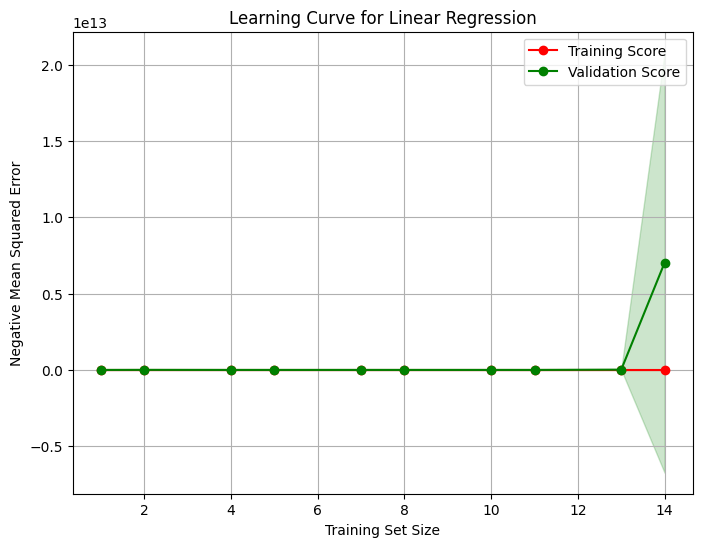

In [14]:
train_sizes, train_scores, val_scores = learning_curve(
    model_linear, X1_train, y_train, train_sizes=np.linspace(0.1,0.01,10)[::-1], cv=5, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Negative Mean Squared Error')
plt.title('Learning Curve for Linear Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()

<ipython-input-15-5a0e9b79f487>:7: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C0', ax=axs)
<ipython-input-15-5a0e9b79f487>:8: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C3', ax=axs)


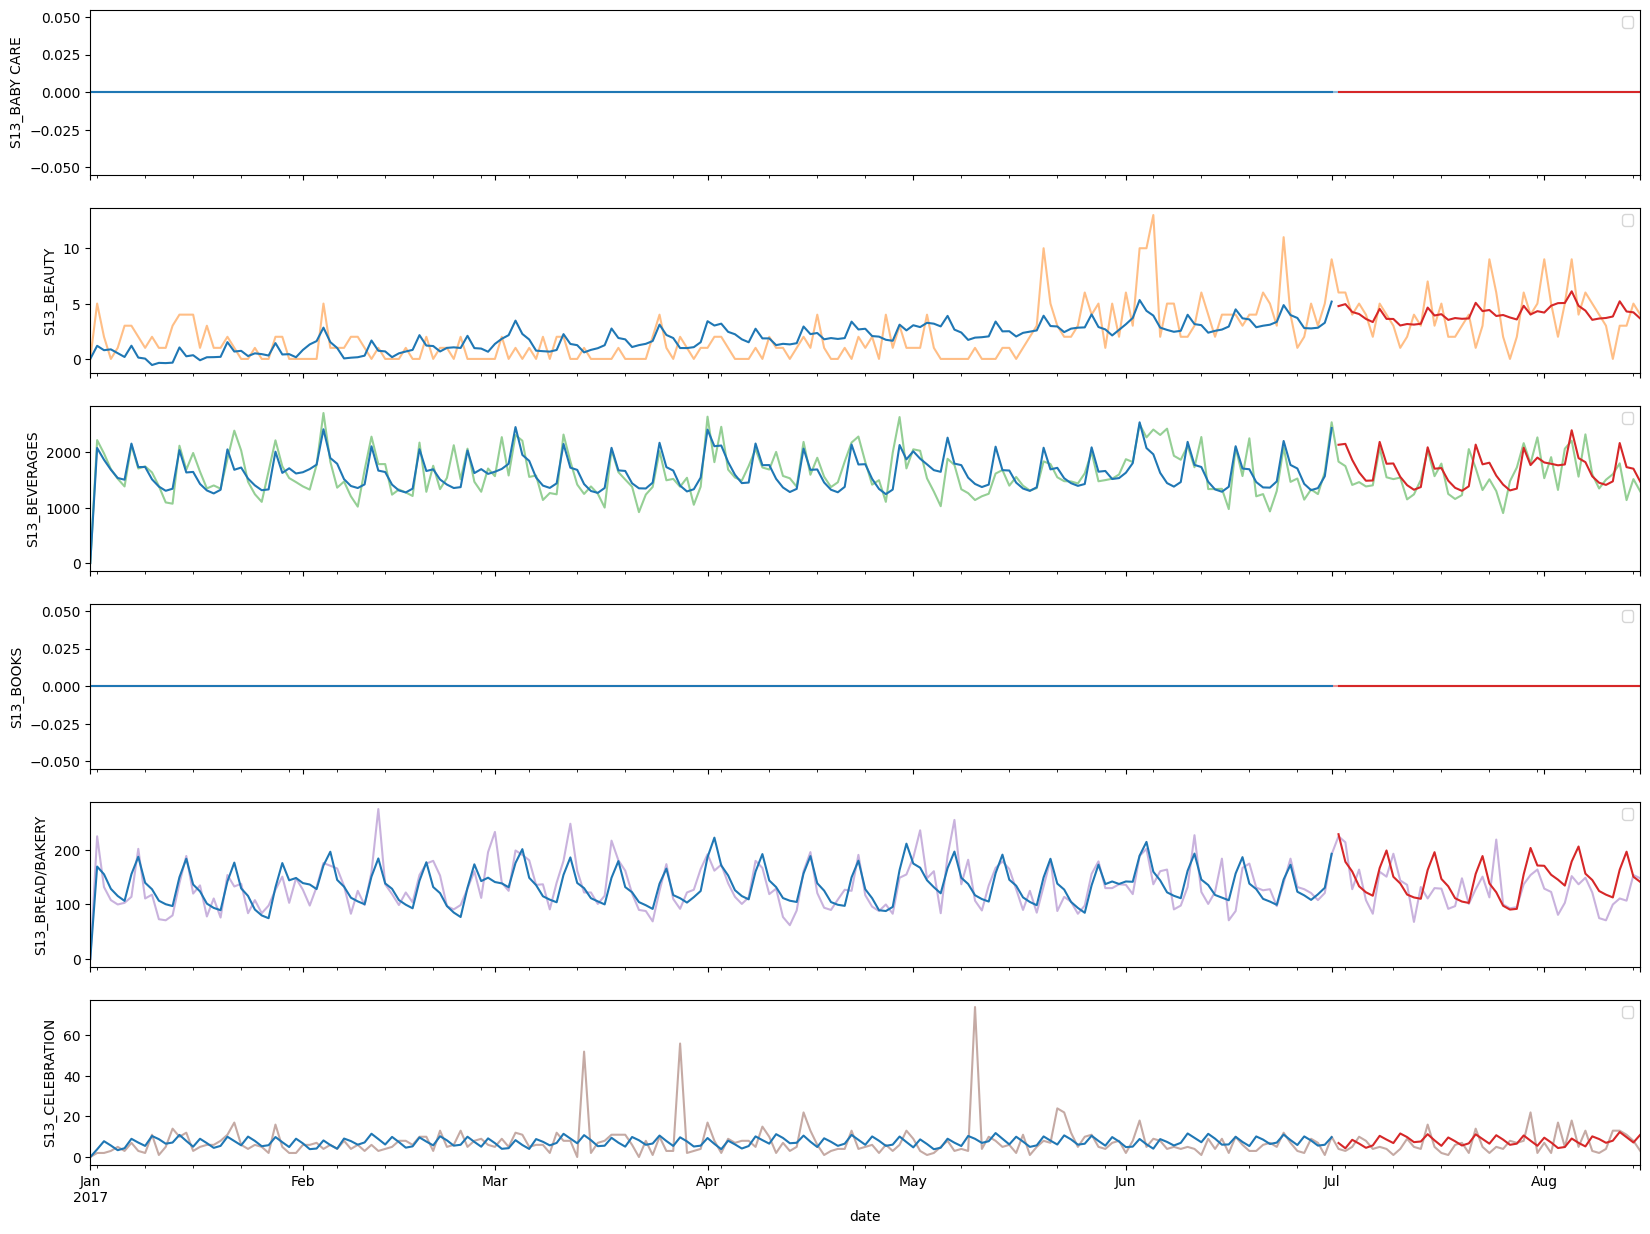

In [15]:
items = y.columns[100:106]
plot_params = {'xlabel': 'Date', 'ylabel': 'Sales', 'grid': True}

axs = y.loc(axis=1)[items].plot(
    subplots=True, sharex=True, figsize=(20, 15), **plot_params, alpha=0.5)

_ = y_fit.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, item in zip(axs, items):
    ax.legend([])
    ax.set_ylabel(item)

In [16]:
model_lasso = Lasso(fit_intercept=False)
history = model_lasso.fit(X1_train, y_train)
y_fit = pd.DataFrame(model_lasso.predict(X1_train), index=X1_train.index, columns=y_train.columns)
y_pred = pd.DataFrame(model_lasso.predict(X1_valid), index=X1_valid.index, columns=y_valid.columns)

#Record performance:
for i,j,k in zip([0,1],[y_train,y_valid],[y_fit,y_pred]):
    metric = dict()
    metric['MAE'] = mean_absolute_error(j, k)
    metric['MSE'] = mean_squared_error(j, k)
    metric['RMSE'] = sqrt(mean_squared_error(j, k))
    metric['R2'] = r2_score(j, k)
    res = pd.DataFrame([metric])
    res.index = ['Classic_Lasso']
    print(res)
    if i == 0:
        val_performance = pd.concat([val_performance, res])
    else:
        performance = pd.concat([performance, res])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


                     MAE           MSE        RMSE        R2
Classic_Lasso  62.106229  60525.010084  246.018312  0.246957
                     MAE           MSE       RMSE        R2
Classic_Lasso  73.884095  67682.700311  260.15899 -4.305998


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.086e+04, tolerance: 8.071e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.588e+04, tolerance: 8.842e+04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

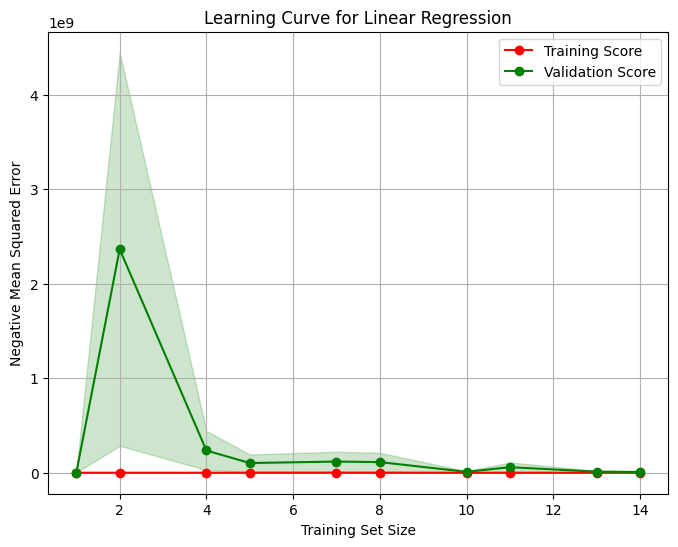

In [17]:
train_sizes, train_scores, val_scores = learning_curve(
    model_lasso, X1_train, y_train, train_sizes=np.linspace(0.1,0.01,10)[::-1], cv=5, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Negative Mean Squared Error')
plt.title('Learning Curve for Linear Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()

<ipython-input-18-5a0e9b79f487>:7: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C0', ax=axs)
<ipython-input-18-5a0e9b79f487>:8: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C3', ax=axs)


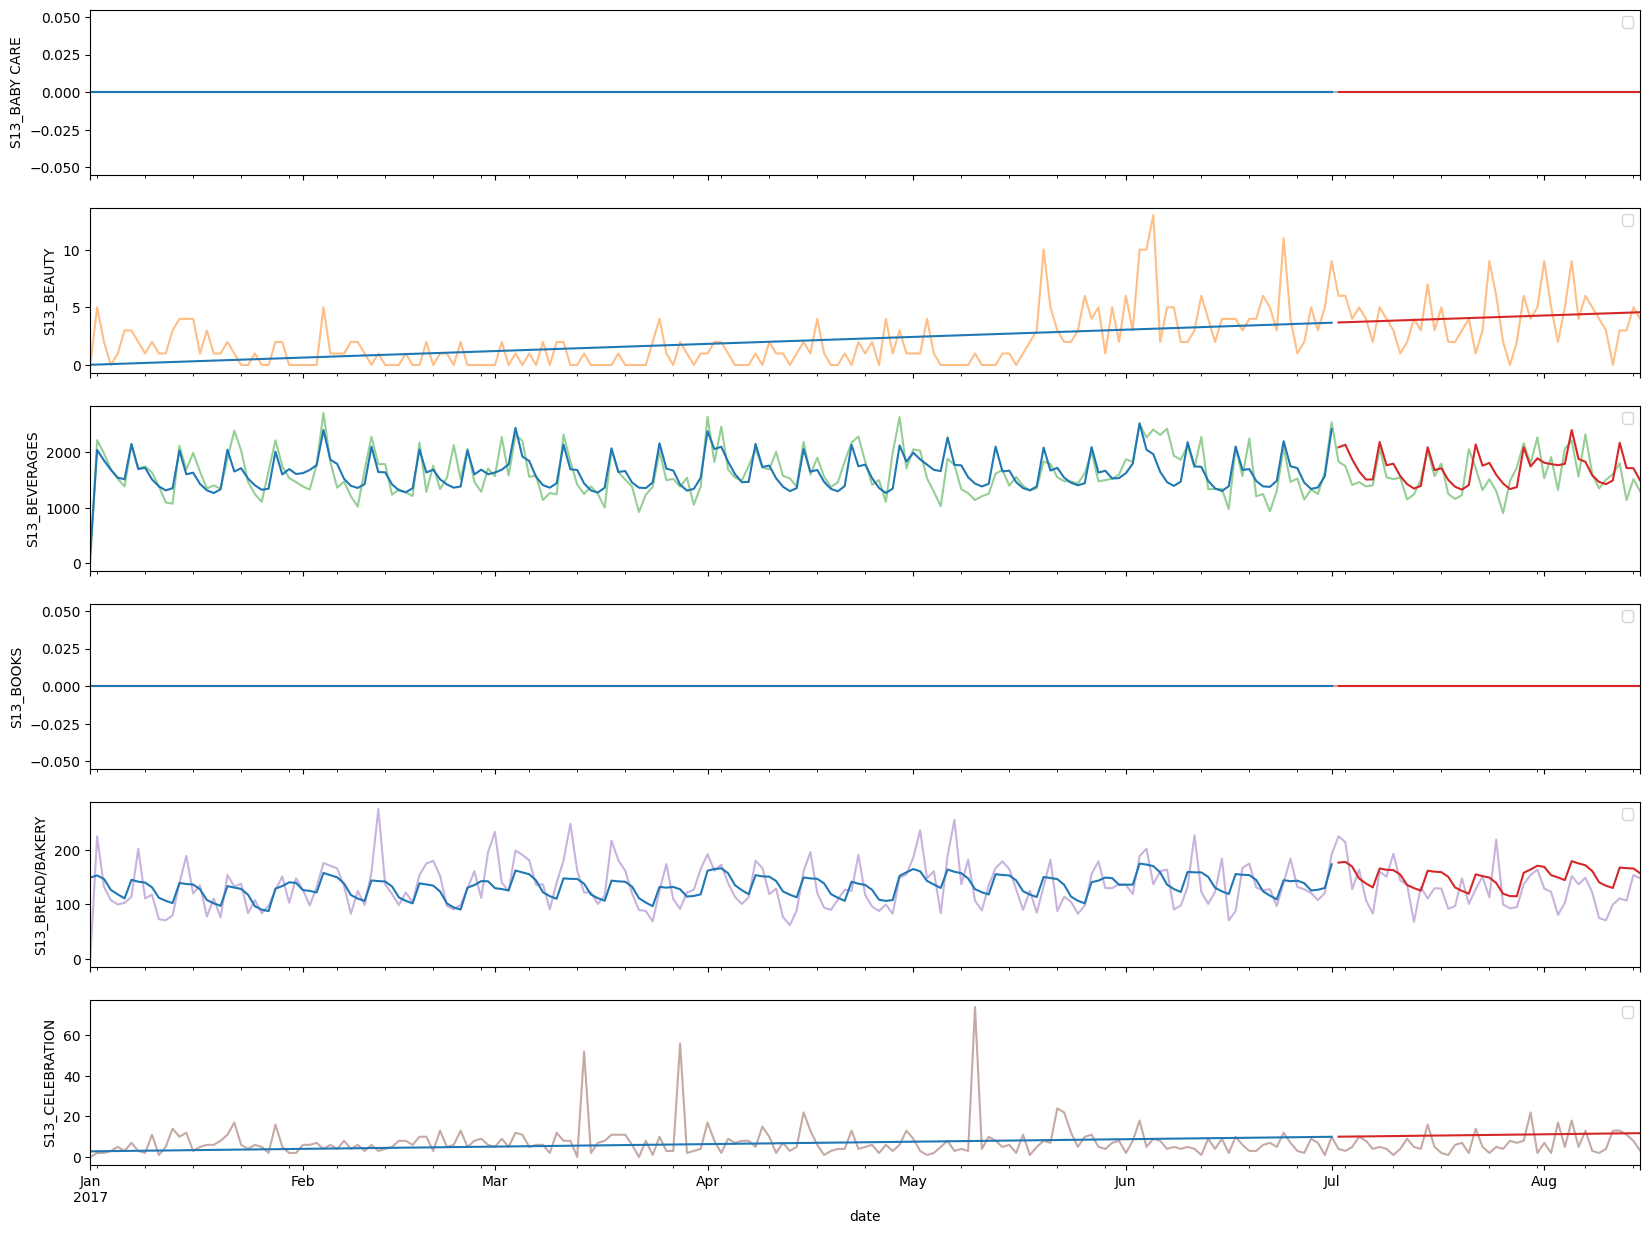

In [18]:
items = y.columns[100:106]
plot_params = {'xlabel': 'Date', 'ylabel': 'Sales', 'grid': True}

axs = y.loc(axis=1)[items].plot(
    subplots=True, sharex=True, figsize=(20, 15), **plot_params, alpha=0.5)

_ = y_fit.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, item in zip(axs, items):
    ax.legend([])
    ax.set_ylabel(item)

In [19]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Feature Scaling
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_valid_scaled = scaler.transform(X1_valid)

# Regularization (Ridge Regression)
ridge_model = Ridge(alpha=1.0)  # Adjust alpha as needed
ridge_model.fit(X1_train_scaled, y_train)
y_fit_ridge = pd.DataFrame(ridge_model.predict(X1_train_scaled), index=X1_train.index, columns=y_train.columns)
y_pred_ridge = pd.DataFrame(ridge_model.predict(X1_valid_scaled), index=X1_valid.index, columns=y_valid.columns)

# Performance Evaluation
for i, j, k in zip([0, 1], [y_train, y_valid], [y_fit_ridge, y_pred_ridge]):
    metric = dict()
    metric['MAE'] = mean_absolute_error(j, k)
    metric['MSE'] = mean_squared_error(j, k)
    metric['RMSE'] = sqrt(mean_squared_error(j, k))
    metric['R2'] = r2_score(j, k)
    res = pd.DataFrame([metric])
    res.index = ['Ridge_Regression']
    print(res)
    if i == 0:
        val_performance = pd.concat([val_performance, res])
    else:
        performance = pd.concat([performance, res])


                        MAE           MSE        RMSE        R2
Ridge_Regression  60.780869  60368.638267  245.700302  0.441354
                        MAE           MSE        RMSE        R2
Ridge_Regression  72.844936  67030.894195  258.903253 -3.353927


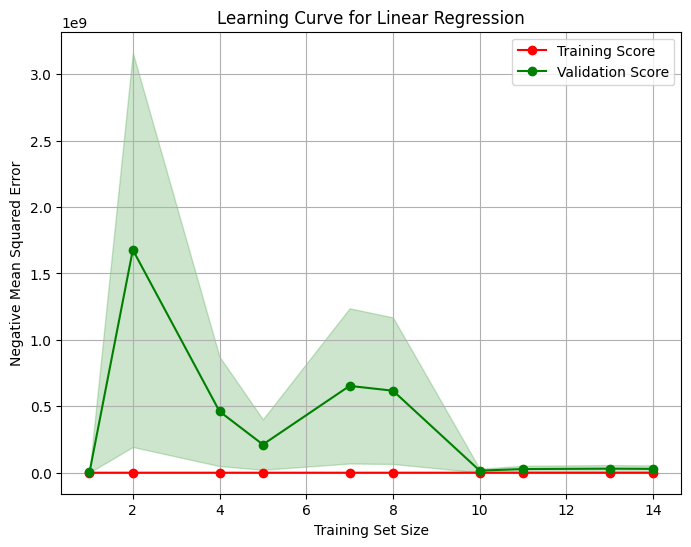

In [20]:
train_sizes, train_scores, val_scores = learning_curve(
    ridge_model, X1_train, y_train, train_sizes=np.linspace(0.1,0.01,10)[::-1], cv=5, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Negative Mean Squared Error')
plt.title('Learning Curve for Linear Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()

<ipython-input-21-5a0e9b79f487>:7: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C0', ax=axs)
<ipython-input-21-5a0e9b79f487>:8: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C3', ax=axs)


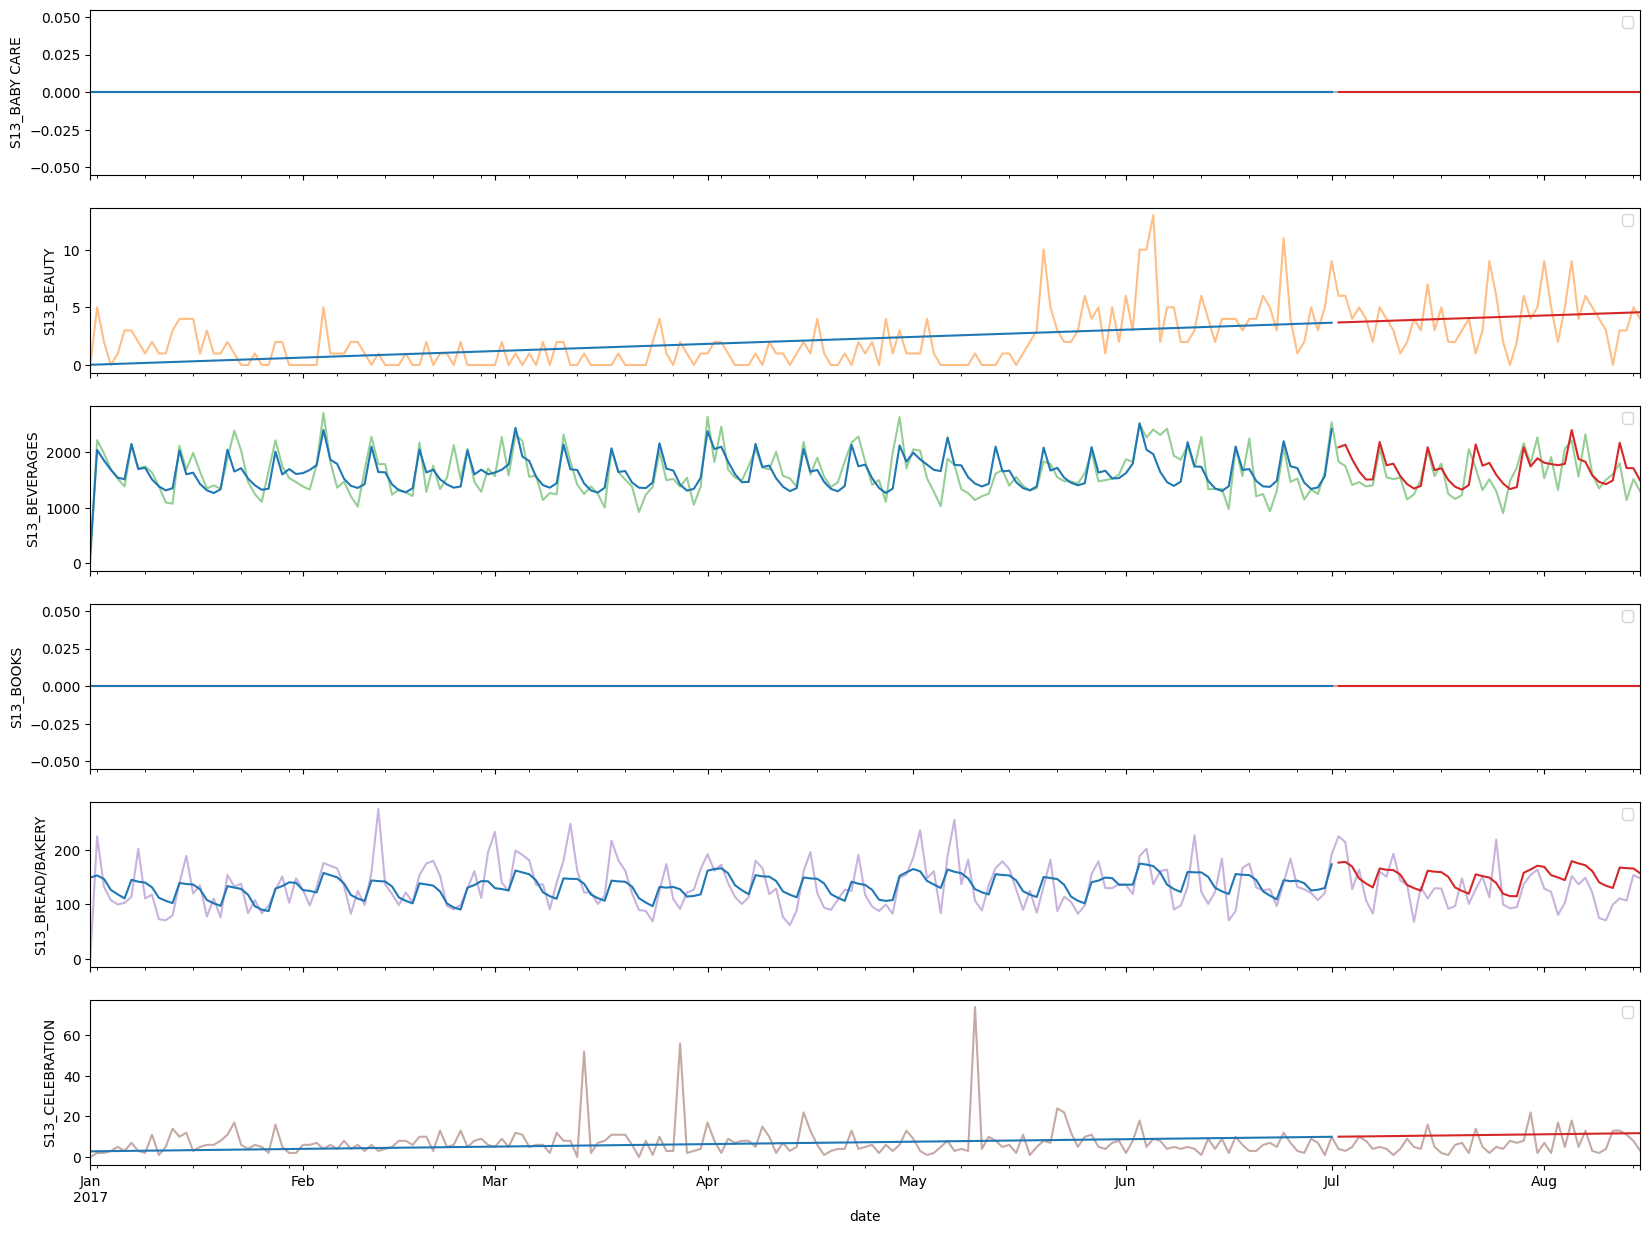

In [21]:
items = y.columns[100:106]
plot_params = {'xlabel': 'Date', 'ylabel': 'Sales', 'grid': True}

axs = y.loc(axis=1)[items].plot(
    subplots=True, sharex=True, figsize=(20, 15), **plot_params, alpha=0.5)

_ = y_fit.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[items].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, item in zip(axs, items):
    ax.legend([])
    ax.set_ylabel(item)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize DataFrame to store performance metrics
performance = pd.DataFrame()

# Iterate over each item
for column in y_train.columns:
    # Fit SARIMA model
    sarima_model = SARIMAX(y_train[column], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_results = sarima_model.fit()

    # Forecast
    forecast = sarima_results.forecast(steps=len(y_valid))

    # Performance Evaluation
    metric = dict()
    metric['MAE'] = mean_absolute_error(y_valid[column], forecast)
    metric['MSE'] = mean_squared_error(y_valid[column], forecast)
    metric['RMSE'] = sqrt(mean_squared_error(y_valid[column], forecast))
    metric['R2'] = r2_score(y_valid[column], forecast)
    res = pd.DataFrame([metric])
    res.index = [column]
    performance = pd.concat([performance, res])

# Display performance metrics
print(performance)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Max

KeyboardInterrupt: 

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.957e+04, tolerance: 1.534e+03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.570e+02, tolerance: 9.702e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

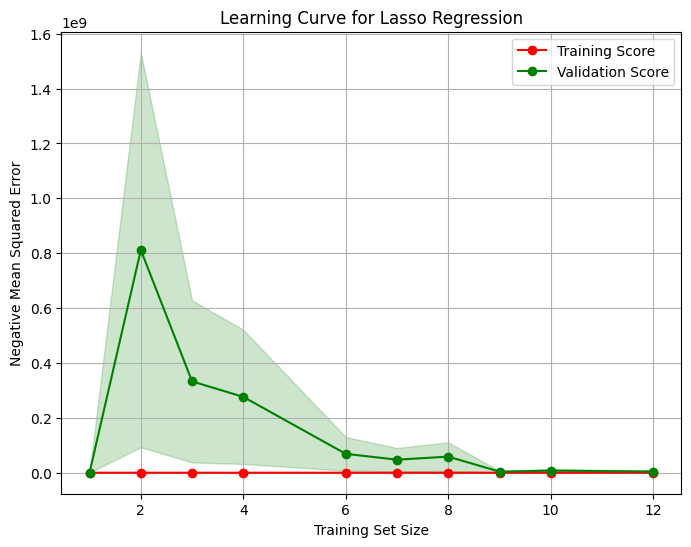

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    model_lasso, X1_train, y_train, train_sizes=np.linspace(0.1,0.01,10)[::-1], cv=5, scoring='neg_mean_squared_error')

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='r')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='g')
plt.xlabel('Training Set Size')
plt.ylabel('Negative Mean Squared Error')
plt.title('Learning Curve for Lasso Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()

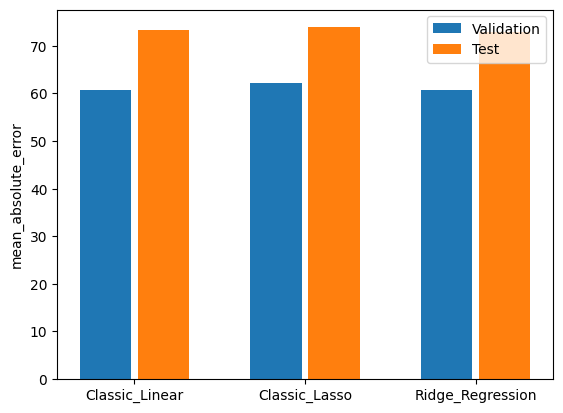

In [22]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = val_performance['MAE'].tolist()
test_mae = performance['MAE'].tolist()

plt.ylabel('mean_absolute_error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=['Classic_Linear', 'Classic_Lasso', 'Ridge_Regression'],
           rotation=0)
_ = plt.legend()


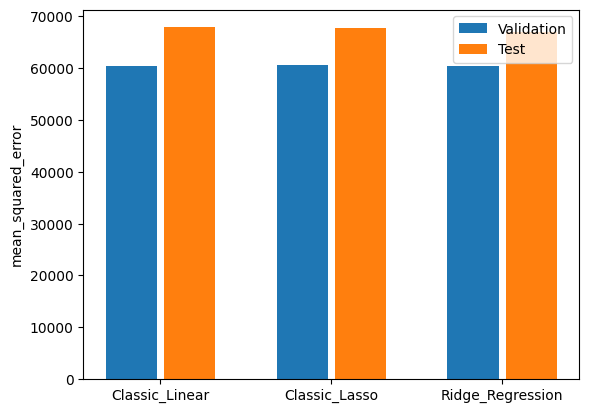

In [23]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error'
val_mae = val_performance['MSE'].tolist()
test_mae = performance['MSE'].tolist()

plt.ylabel('mean_squared_error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=['Classic_Linear','Classic_Lasso', 'Ridge_Regression'],
           rotation=0)
_ = plt.legend()

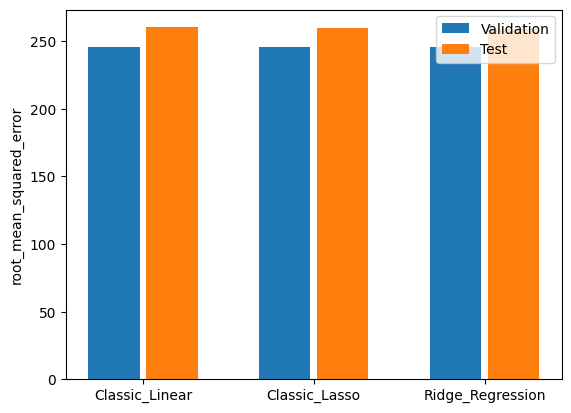

In [24]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'root_mean_squared_error'
val_mae = val_performance['RMSE'].tolist()
test_mae = performance['RMSE'].tolist()

plt.ylabel('root_mean_squared_error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=['Classic_Linear','Classic_Lasso', 'Ridge_Regression'],
           rotation=0)
_ = plt.legend()

In [25]:
print("Training Performance")
print(performance.head())

print("\n\nValidation Performance")
print(val_performance.head())

Training Performance
                        MAE           MSE        RMSE        R2
Classic_Linear    73.219922  67882.505357  260.542713 -3.378452
Classic_Lasso     73.884095  67682.700311  260.158990 -4.305998
Ridge_Regression  72.844936  67030.894195  258.903253 -3.353927


Validation Performance
                        MAE           MSE        RMSE        R2
Classic_Linear    60.669719  60307.913637  245.576696  0.441475
Classic_Lasso     62.106229  60525.010084  246.018312  0.246957
Ridge_Regression  60.780869  60368.638267  245.700302  0.441354


In [31]:
# Create features for test set
X1_test = dp.out_of_sample(steps=16)
X1_test.index.name = 'date'
X1_test['NewYear'] = (X1_test.index.dayofyear == 1)

In [32]:
y_submit = pd.DataFrame(model_linear.predict(X1_test), index=X1_test.index, columns=y.columns)
y_submit = pd.DataFrame(y_submit.stack(['item']))
y_submit = pd.merge(y_submit, df_test, how='inner', on=['date','item']).reset_index()
y_submit.drop(['date', 'item', 'store_nbr', 'family', 'onpromotion','available'], axis=1, inplace=True)
y_submit.columns = ['sales', 'id']
y_submit.to_csv('submission.csv', index=False)

In [28]:
xgb_params = {
    'max_depth':10,           # maximum depth of each tree - try 2 to 10
    'learning_rate':0.01,    # effect of each tree - try 0.0001 to 0.1
    'n_estimators':1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    'min_child_weight':1,    # minimum number of houses in a leaf - try 1 to 10
    'colsample_bytree':0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    'subsample':0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    'reg_alpha':0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    'reg_lambda':1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    'num_parallel_tree':1,
}

mlp_params = {
    'alpha':0.0001,
    'early_stopping':True,
}


mlp_deep_params = {
    'hidden_layer_sizes':512,
    'activation':'tanh',
    'early_stopping':True,
    'alpha':0.01
}

In [29]:
y_fit.shape

(182, 1782)

In [30]:
y_pred.shape

(45, 1782)